In [1]:
# import libraries and magics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras

In [2]:
# Define function for evaluating performance
def Evaluate_performance(model, Name, X_test, t_test, history=None, display=True):
    
    y_test = np.argmax(model.predict(X_test),axis=1)
    
    # Accuracy
    test_acc = accuracy_score(y_test, t_test)
    
    # Print performance
    print('Performance of {}:\n'.format(Name))
    print('In test set: ')
    print(classification_report(t_test, y_test))
    print('Accuracy: {}'.format(test_acc))
    print('Confusion Matrix')
    print(confusion_matrix(t_test, y_test))
    
    # Display learning curve
    if display==True:
        key_names = list(history.history.keys())
        colors = ['-r','--b','-og','-.k']

        plt.figure(figsize=(8,5))
        for i in [0,2]:
            plt.plot(history.history[key_names[i]], colors[i], label=key_names[i])
        plt.legend(fontsize=15,ncol=2)
        plt.title('Learning Curves with loss', size=15);
        
        plt.figure(figsize=(8,5))
        for i in [1,3]:
            plt.plot(history.history[key_names[i]], colors[i], label=key_names[i])
        plt.legend(fontsize=15,ncol=2)
        plt.title('Learning Curves with accuracy', size=15);



### Problem 1

In [3]:
# load the data
X_test = np.load('flower_species_classification/data_test.npy').T
t_test = np.load('flower_species_classification/labels_test.npy')

class_names = ['Roses', 'Magnolias', 'Lilies', 'Sunflowers', 'Orchids', 
               'Marigold', 'Hibiscus', 'Firebush', 'Pentas', 'Bougainvillea']

# Scale the training data
X_test_scaled = X_test / 255.0

X_test.shape, t_test.shape

((415, 270000), (415,))

In [5]:
X_test_rs = tf.constant(X_test_scaled.reshape((X_test_scaled.shape[0],300,300,3)),
                        dtype=tf.float16)

In [6]:
model = keras.models.load_model('Model/model_problem1_three.h5')

In [8]:
Evaluate_performance(model=model, Name='Transfer learning model' , X_test=X_test_rs, t_test=t_test, display=False)

Performance of Transfer learning model:

In test set: 
              precision    recall  f1-score   support

         0.0       0.80      0.83      0.82        48
         1.0       0.95      0.91      0.93        44
         2.0       0.80      0.76      0.78        46
         3.0       1.00      0.92      0.96        36
         4.0       0.88      0.80      0.84        45
         5.0       0.88      0.95      0.92        40
         6.0       0.87      0.91      0.89        43
         7.0       0.85      0.92      0.88        37
         8.0       0.91      0.91      0.91        32
         9.0       0.76      0.77      0.76        44

    accuracy                           0.86       415
   macro avg       0.87      0.87      0.87       415
weighted avg       0.86      0.86      0.86       415

Accuracy: 0.8626506024096385
Confusion Matrix
[[40  0  1  0  0  2  1  2  0  2]
 [ 0 40  1  0  1  0  0  2  0  0]
 [ 1  1 35  0  3  0  1  1  0  4]
 [ 0  0  0 33  0  1  0  0  1  1]
 [ 2  0 

### Problem 2 & 3

In [3]:
# Load ten of the test data
bbox = pd.read_csv('test_bounding_boxes.csv')

N = len(bbox)

# Create a numpy array with all images
for i in range(N): 
    filename='car_detection_dataset/testing_images/'+bbox['image_name'][i]
    image = np.array(Image.open(filename))
    image_col = image.ravel()[:,np.newaxis]
    
    if i==0:
        X_test = image_col
    else:
        X_test = np.hstack((X_test, image_col))

# Test feature matrices
X_test = X_test.T

# Test labels
t_test = bbox[['bbox_x','bbox_y', 'bbox_width', 'bbox_height']].round().to_numpy().astype(int)
t_test[:,2] = t_test[:,0] + t_test[:,2]
t_test[:,3] = t_test[:,1] + t_test[:,3]

(Nx,Ny,Nz) = image.shape

X_test.shape, t_test.shape

((10, 770640), (10, 4))

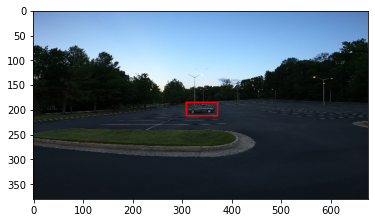

In [4]:
# Example of object visualization using opencv rectangle function
idx=9
x = image

cv2.rectangle(x, (t_test[idx,0], t_test[idx,1]), 
              (t_test[idx,2], t_test[idx,3]), 
              (255, 0, 0), 2);
plt.imshow(image)

In [6]:
X_test_scaled = X_test / 255.0
t_test_scaled = np.vstack((t_test[:,0]/Ny, t_test[:,1]/Nx, t_test[:,2]/Ny, t_test[:,3]/Nx)).T

X_test_rs = tf.constant(X_test_scaled.reshape((X_test_scaled.shape[0], Nx,Ny,3)), 
                        dtype=tf.float16)

X_test_rs.shape, t_test_scaled.shape

(TensorShape([10, 380, 676, 3]), (10, 4))

In [7]:
# Load the model
model = keras.models.load_model('Model/model_problem2.h5')

In [9]:
y_test_scaled = model.predict(X_test_rs)
y_test = np.vstack((y_test_scaled[:,0]*Ny, y_test_scaled[:,1]*Nx, y_test_scaled[:,2]*Ny, y_test_scaled[:,3]*Nx)).T
y_test = np.array(y_test, dtype='int')
y_test

array([[229, 186, 355, 241],
       [514, 181, 611, 205],
       [ 70, 188, 182, 237],
       [352, 188, 501, 234],
       [530, 174, 625, 205],
       [125, 186, 250, 248],
       [ 56, 190, 184, 241],
       [195, 185, 292, 232],
       [461, 183, 583, 224],
       [430, 184, 545, 228]])

#### Discuss how you would validate performance in the test set given that no target labels are provided:

Firstly, I use the MakeSenseAI creating my own test labels. Then use ROI to validate performance.

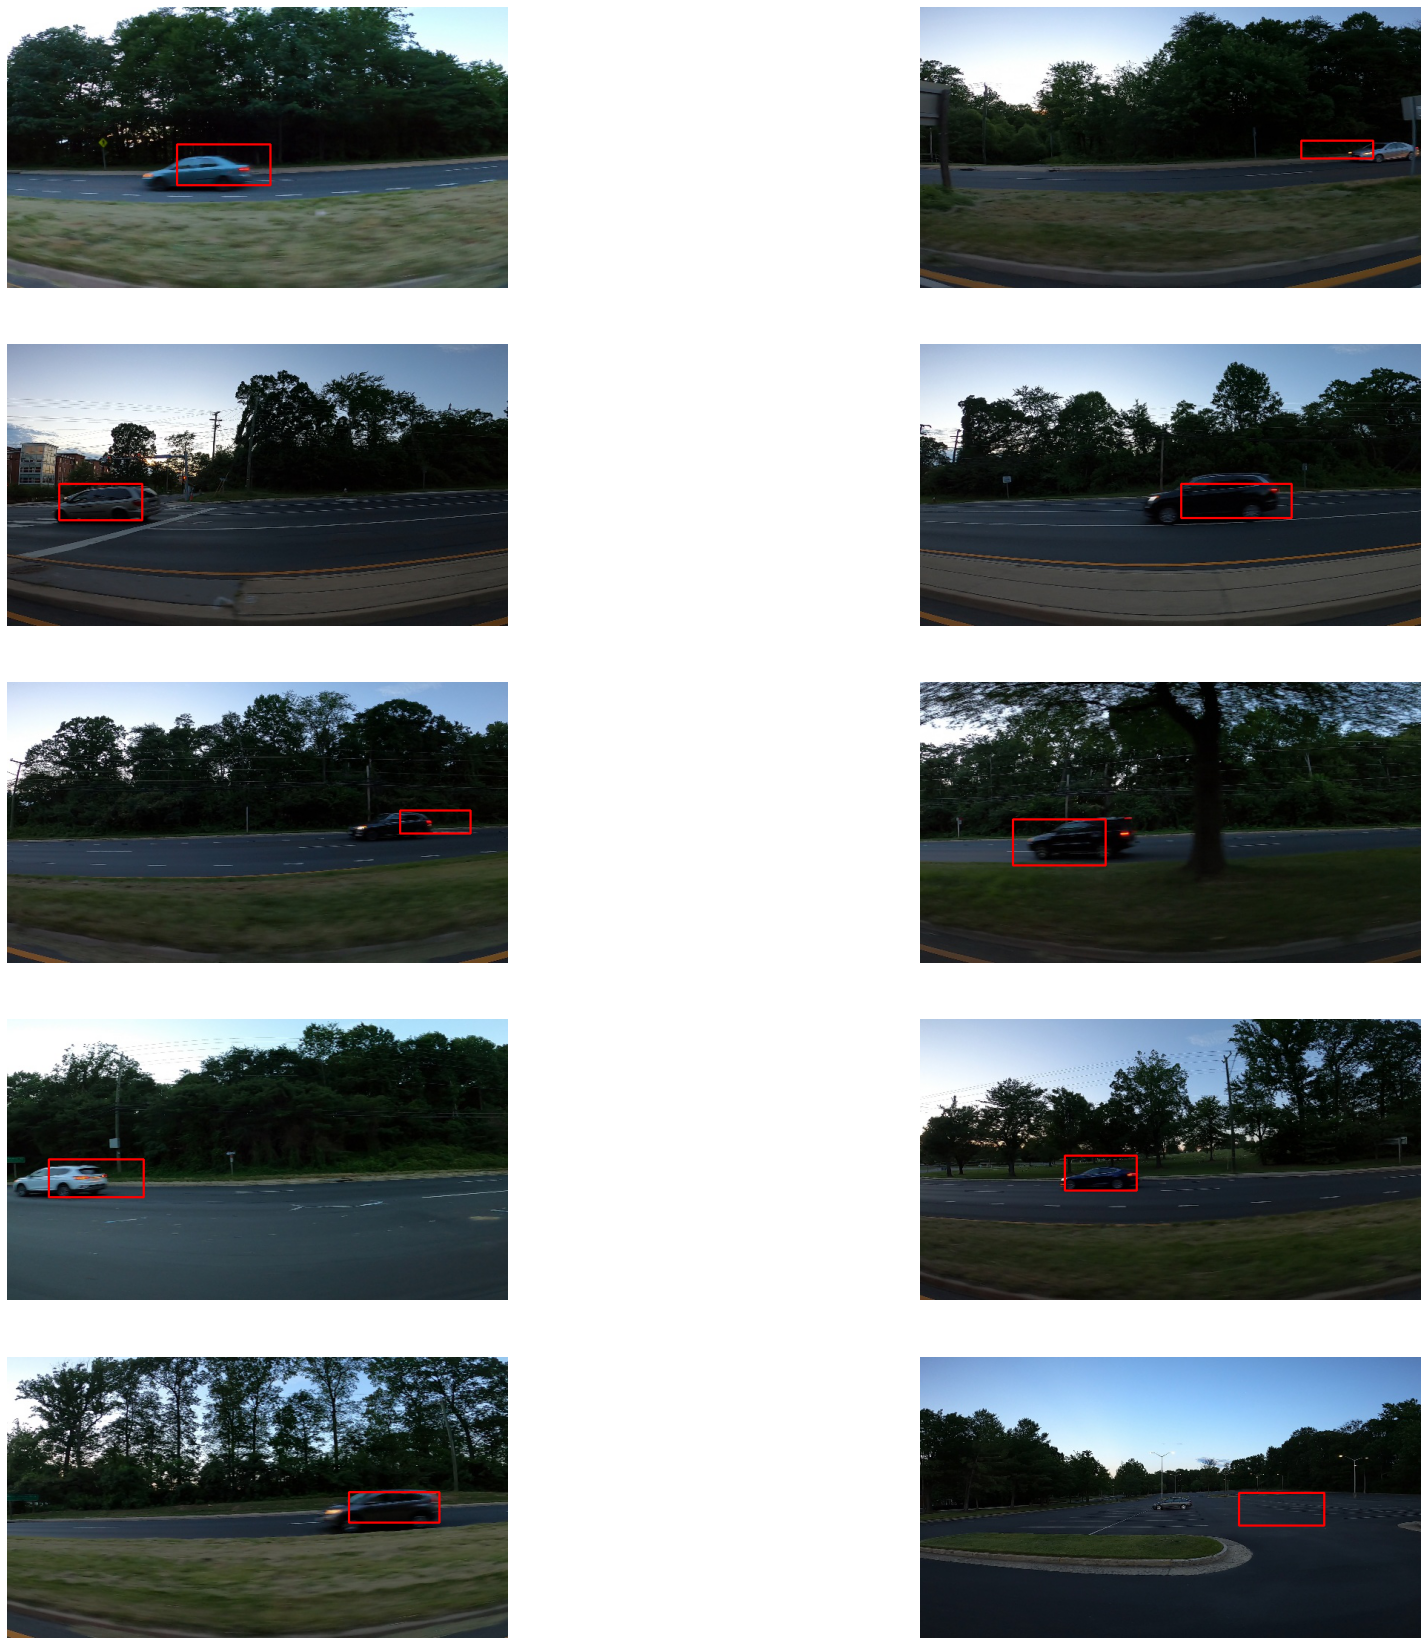

In [11]:
# visualization of test result
plt.figure(figsize=(30,30))
for idx in range(N):
    filename='car_detection_dataset/testing_images/'+bbox['image_name'][idx]
    image = np.array(Image.open(filename))
    
    plt.subplot(5,2,idx+1)
    cv2.rectangle(image, (y_test[idx,0], y_test[idx,1]), 
              (y_test[idx,2], y_test[idx,3]), 
              (255, 0, 0), 2);
    plt.imshow(image)
    
    plt.axis('off')

The validation metric I use is overlapping Region of Interest.It calculates the overlapping region between test bounding box and predict bounding box divided by area of test bounding box. The accuracy score is between 0 and 1, and when the accuracy score is 1.0, it represents an exact match. In practice, an accuracy score below 0.5 is probably an incorrect match.

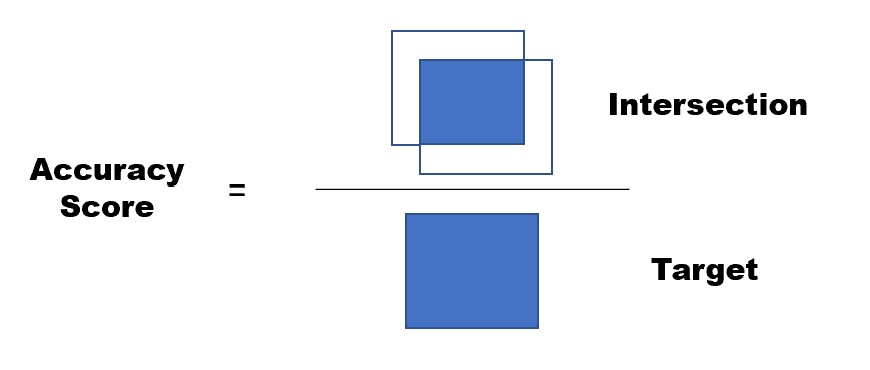

In [12]:
from IPython.display import Image
Image('figures/ROI.jpg',width=400)

In [13]:
# Define intersection over union function to validate the performance of the test dataset
def Region_of_Interest(box_a, box_b):
    # Assign value for each coordinate in two boxes
    a_xmin = box_a[0]
    a_ymin = box_a[1]
    a_xmax = box_a[2]
    a_ymax = box_a[3]
    
    b_xmin = box_b[0]
    b_ymin = box_b[1]
    b_xmax = box_b[2]
    b_ymax = box_b[3]

    # Determine the coordinates of each of the two boxes
    xA = max(a_xmin, b_xmin)
    yA = max(a_ymin, b_ymin)
    xB = min(a_xmax, b_xmax)
    yB = min(a_ymax, b_ymax)

    # Calculate the area of the intersection area
    area_of_intersection = (xB - xA + 1) * (yB - yA + 1)

    # Calculate the area of both rectangles
    box_a_area = (a_xmax - a_xmin + 1) * (a_ymax - a_ymin + 1)
    box_b_area = (b_xmax - b_xmin + 1) * (b_xmax - b_xmin + 1)
    
    # Calculate the area of intersection divided by the area of union
    # Area of union = sum both areas less the area of intersection
    roi = area_of_intersection / float(box_a_area)
    if roi <= 0:
        roi = 0

    return roi

In [14]:
# Define a empty list to restore the accuracy score of each image
acc_score = []

for i in range(t_test.shape[0]):
    box_a = t_test[i,:]
    box_b = y_test[i,:]
    score = Region_of_Interest(box_a, box_b)
    acc_score.append(score)
    
acc_score

[0.5138888888888888,
 0.2230246389124894,
 0.6089897947483087,
 0.3913910391742904,
 0.23428650366072662,
 0.6184049079754601,
 0.5638067772170151,
 0.7194444444444444,
 0.40327868852459015,
 0]

In [19]:
acc_mean = sum(acc_score) / len(acc_score)
acc_mean

0.4276515683546214

#### Discuss also how you would address the case where no car is present in the image:

Consider the case where no car is present in the images. I have two approaches to achieve it. First approach is to train two CNN models. One model does the image classification task to determine whether there is a car in the image, and if the determination is positive, then the other model will do the car detection work. The second approach is to train the images all together and set a certain bounding boxed’ coordinates to the image without cars, for instance, set the label [0, 0, 0, 0] for all images without a car.